# 02 - Exploratory Data Analysis (EDA)

## Objective
**WHY are we doing this analysis?**

After understanding the basic structure of our data, we now explore **relationships** between features and the target (MOS). The goals are:

1. **Discover patterns:** Which QoE Influence Factors correlate with user satisfaction?
2. **Identify non-linear relationships:** Prepare for model selection decisions
3. **Find interactions:** Do certain combinations of factors matter more?
4. **Guide feature engineering:** What transformations or new features could help?

**Important Note (Following Guidelines):**
- We will NOT report every single finding
- Only **interesting and useful** patterns will be highlighted
- Focus on actionable insights for modeling

---

## 1. Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%config InlineBackend.figure_format = 'retina'

# Load preprocessed data (or raw if preprocessing not done yet)
df = pd.read_csv('../data/raw/pokemon.csv')

print(f"✓ Data loaded: {df.shape}")

✓ Data loaded: (1543, 23)


## 2. Correlation Analysis

**WHY:** Identify which numerical features have linear relationships with MOS and with each other (multicollinearity check).

In [2]:
# Select numerical features for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols = [c for c in numerical_cols if c not in ['id', 'user_id']]

# Calculate correlation matrix
corr_matrix = df[numerical_cols].corr()

# Correlation with MOS (target)
mos_corr = corr_matrix['MOS'].sort_values(ascending=False)
print("Correlation with MOS (sorted):")
print("="*60)
for feat, corr in mos_corr.items():
    if feat != 'MOS':
        print(f"{feat:30s}: {corr:+.3f}")

Correlation with MOS (sorted):
QoF_audio                     : +0.841
QoF_video                     : +0.689
QoF_shift                     : +0.634
QoF_begin                     : +0.591
QoA_VLCframerate              : +0.544
QoA_VLCaudiorate              : +0.354
QoS_type                      : +0.147
QoD_api-level                 : +0.134
QoA_VLCbitrate                : +0.090
QoU_sex                       : +0.062
QoU_Ustedy                    : +0.056
QoS_operator                  : +0.048
QoA_VLCresolution             : -0.022
QoU_age                       : -0.039
QoA_VLCdropped                : -0.237
QoA_VLCaudioloss              : -0.323
QoA_BUFFERINGcount            : -0.411
QoA_BUFFERINGtime             : -0.482


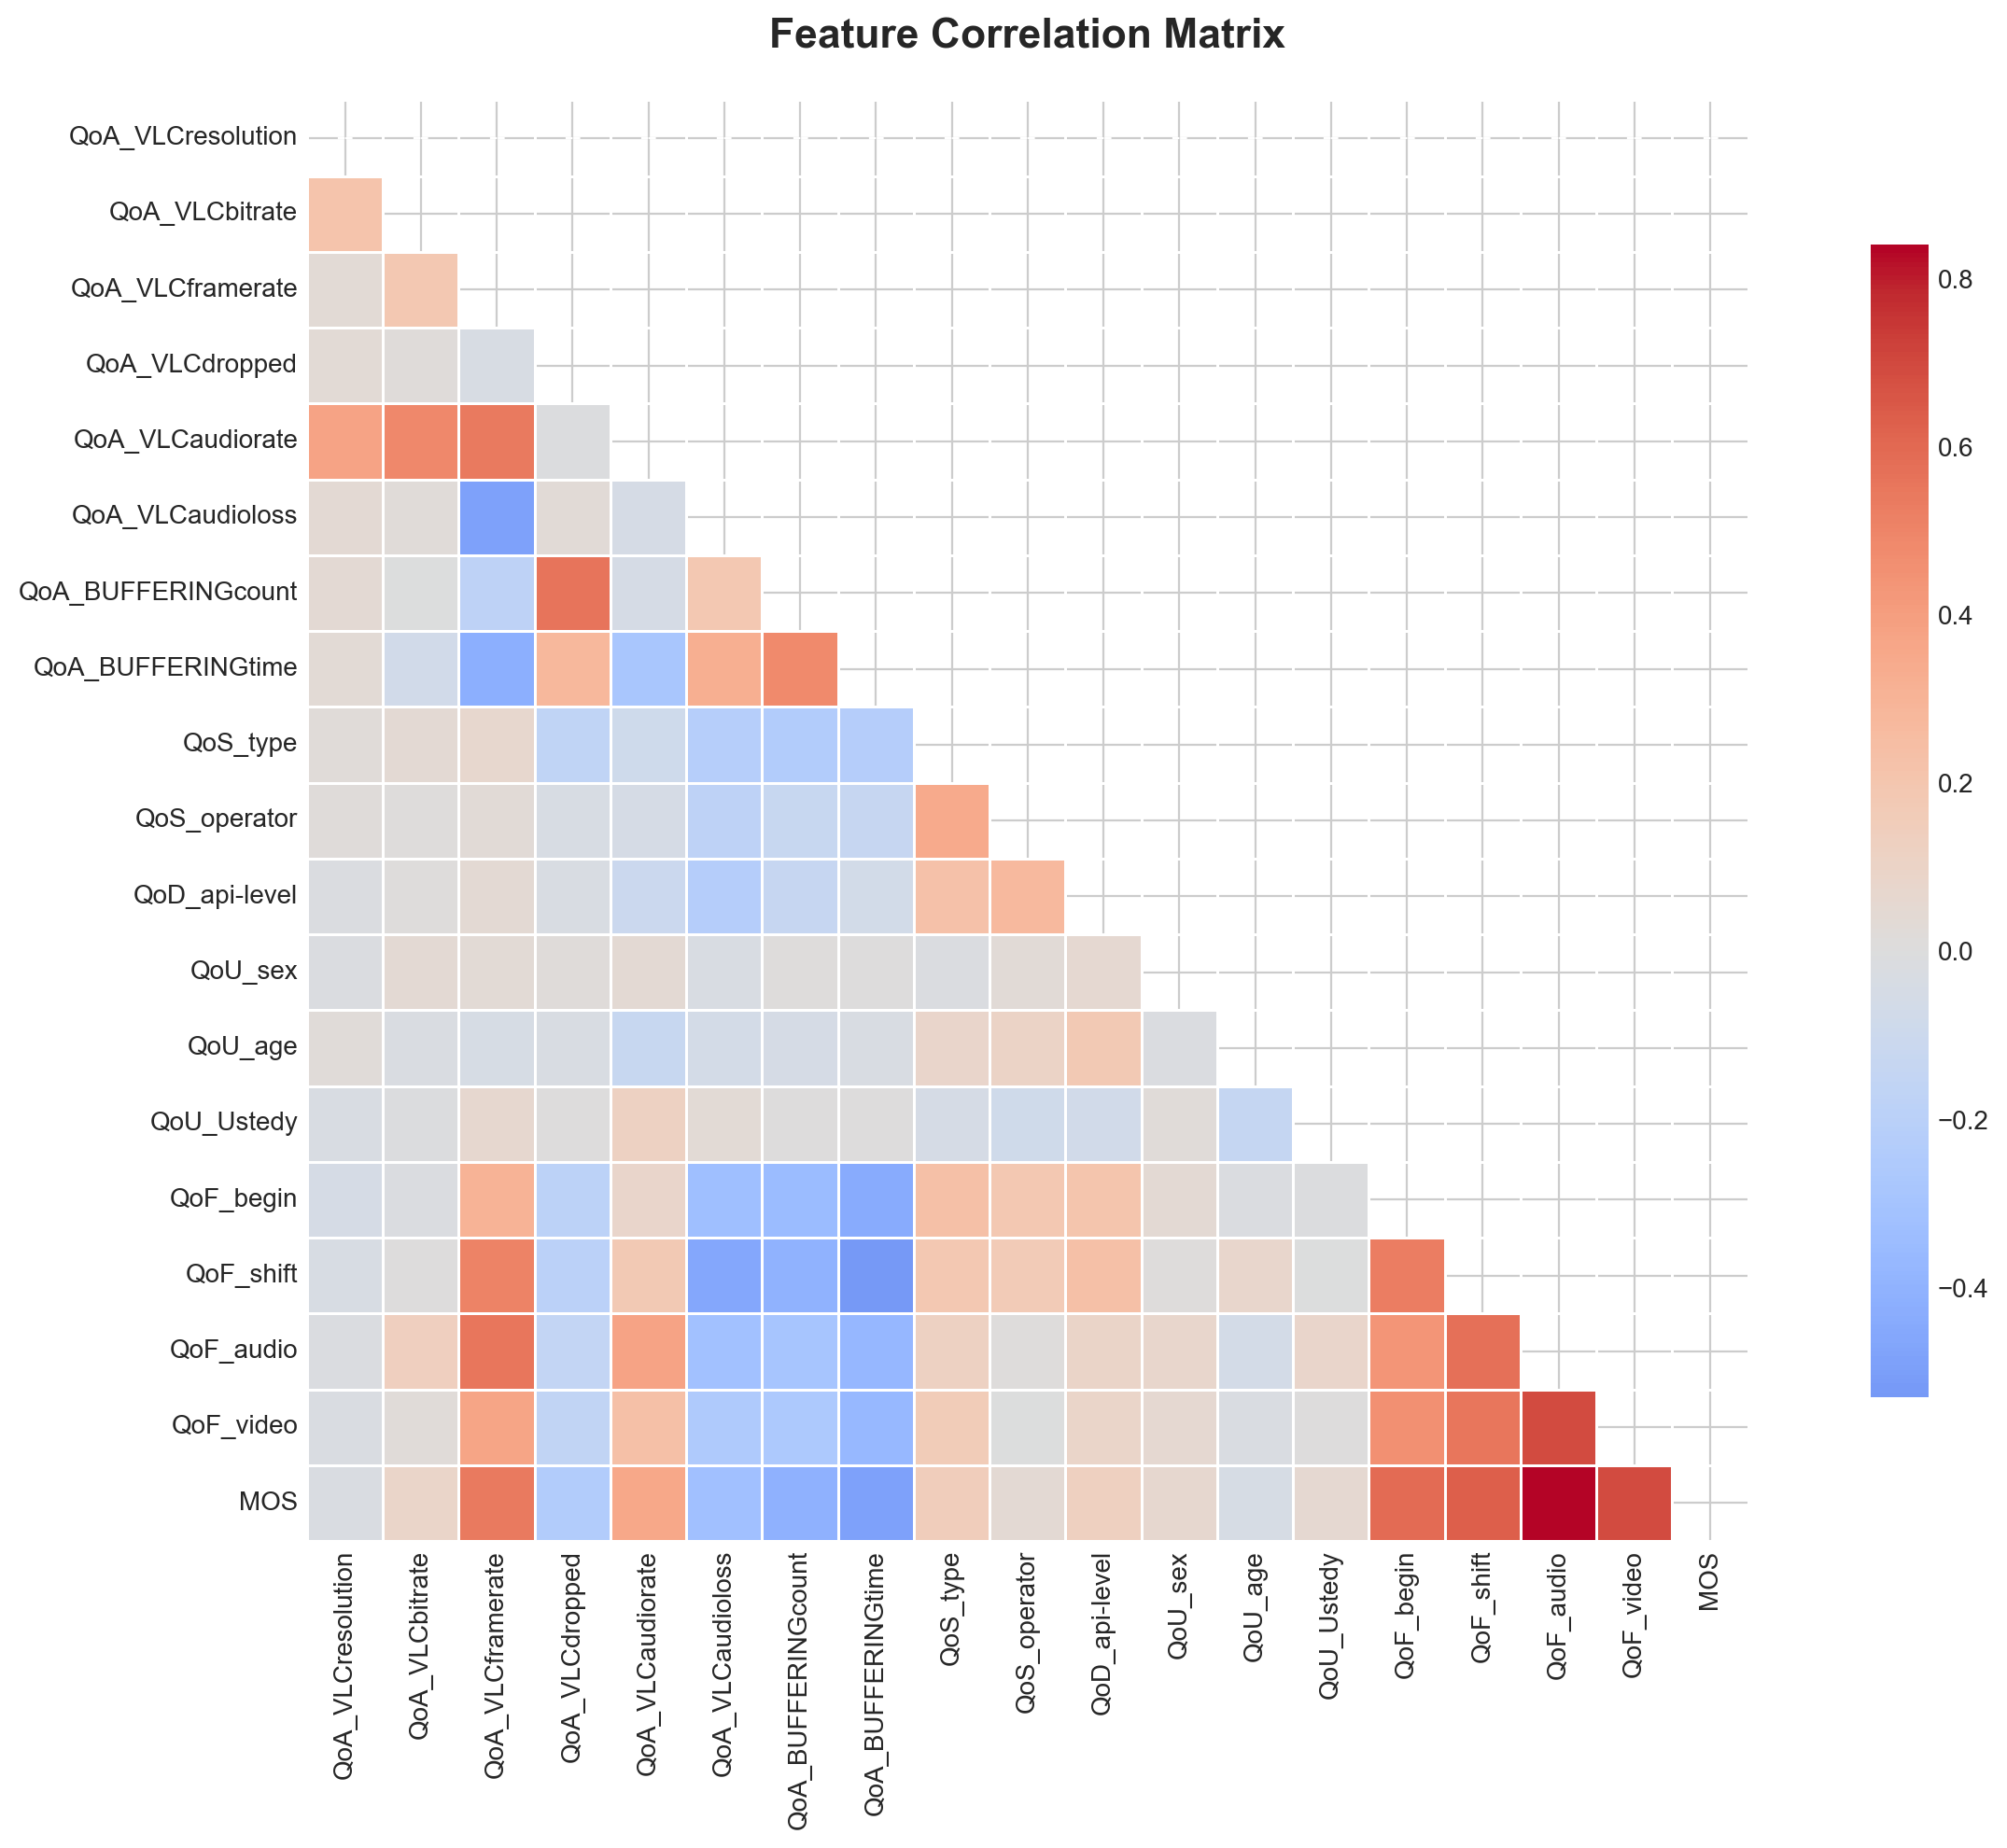

✓ Saved correlation matrix


In [3]:
# Visualize correlation matrix
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, square=True,
            linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../results/figures/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Saved correlation matrix")

### Analysis Path:
**Expected:** We expect buffering events and dropped frames to negatively correlate with MOS.

**Actual:** [To be filled]

**Insights:**
- [Which features show strong correlation?]
- [Any surprising weak/strong correlations?]
- [Multicollinearity concerns?]

## 3. Network Type Impact on MOS

**WHY:** Network quality (EDGE vs LTE) is expected to significantly impact user experience. Let's verify this hypothesis.

In [5]:
# Map network types (from documentation)
network_mapping = {
    1: 'EDGE',
    2: 'UMTS',
    3: 'HSPA',
    4: 'HSPAP',
    5: 'LTE'
}

df['Network_Type_Name'] = df['QoS_type'].map(network_mapping)

# MOS by Network Type
network_mos = df.groupby('Network_Type_Name')['MOS'].agg([
    ('Count', 'count'),
    ('Mean_MOS', 'mean'),
    ('Std_MOS', 'std'),
    ('Median_MOS', 'median')
]).round(2)

# Sort by network generation (EDGE -> LTE)
network_order = ['EDGE', 'UMTS', 'HSPA', 'HSPAP', 'LTE']
network_mos = network_mos.reindex([n for n in network_order if n in network_mos.index])

print("MOS Statistics by Network Type:")
print("="*70)
print(network_mos)

MOS Statistics by Network Type:
                   Count  Mean_MOS  Std_MOS  Median_MOS
Network_Type_Name                                      
EDGE                  27      1.56     0.80         1.0
UMTS                 399      3.64     1.09         4.0
HSPA                  72      3.26     1.44         4.0
HSPAP                572      3.84     0.95         4.0
LTE                  473      3.78     0.94         4.0


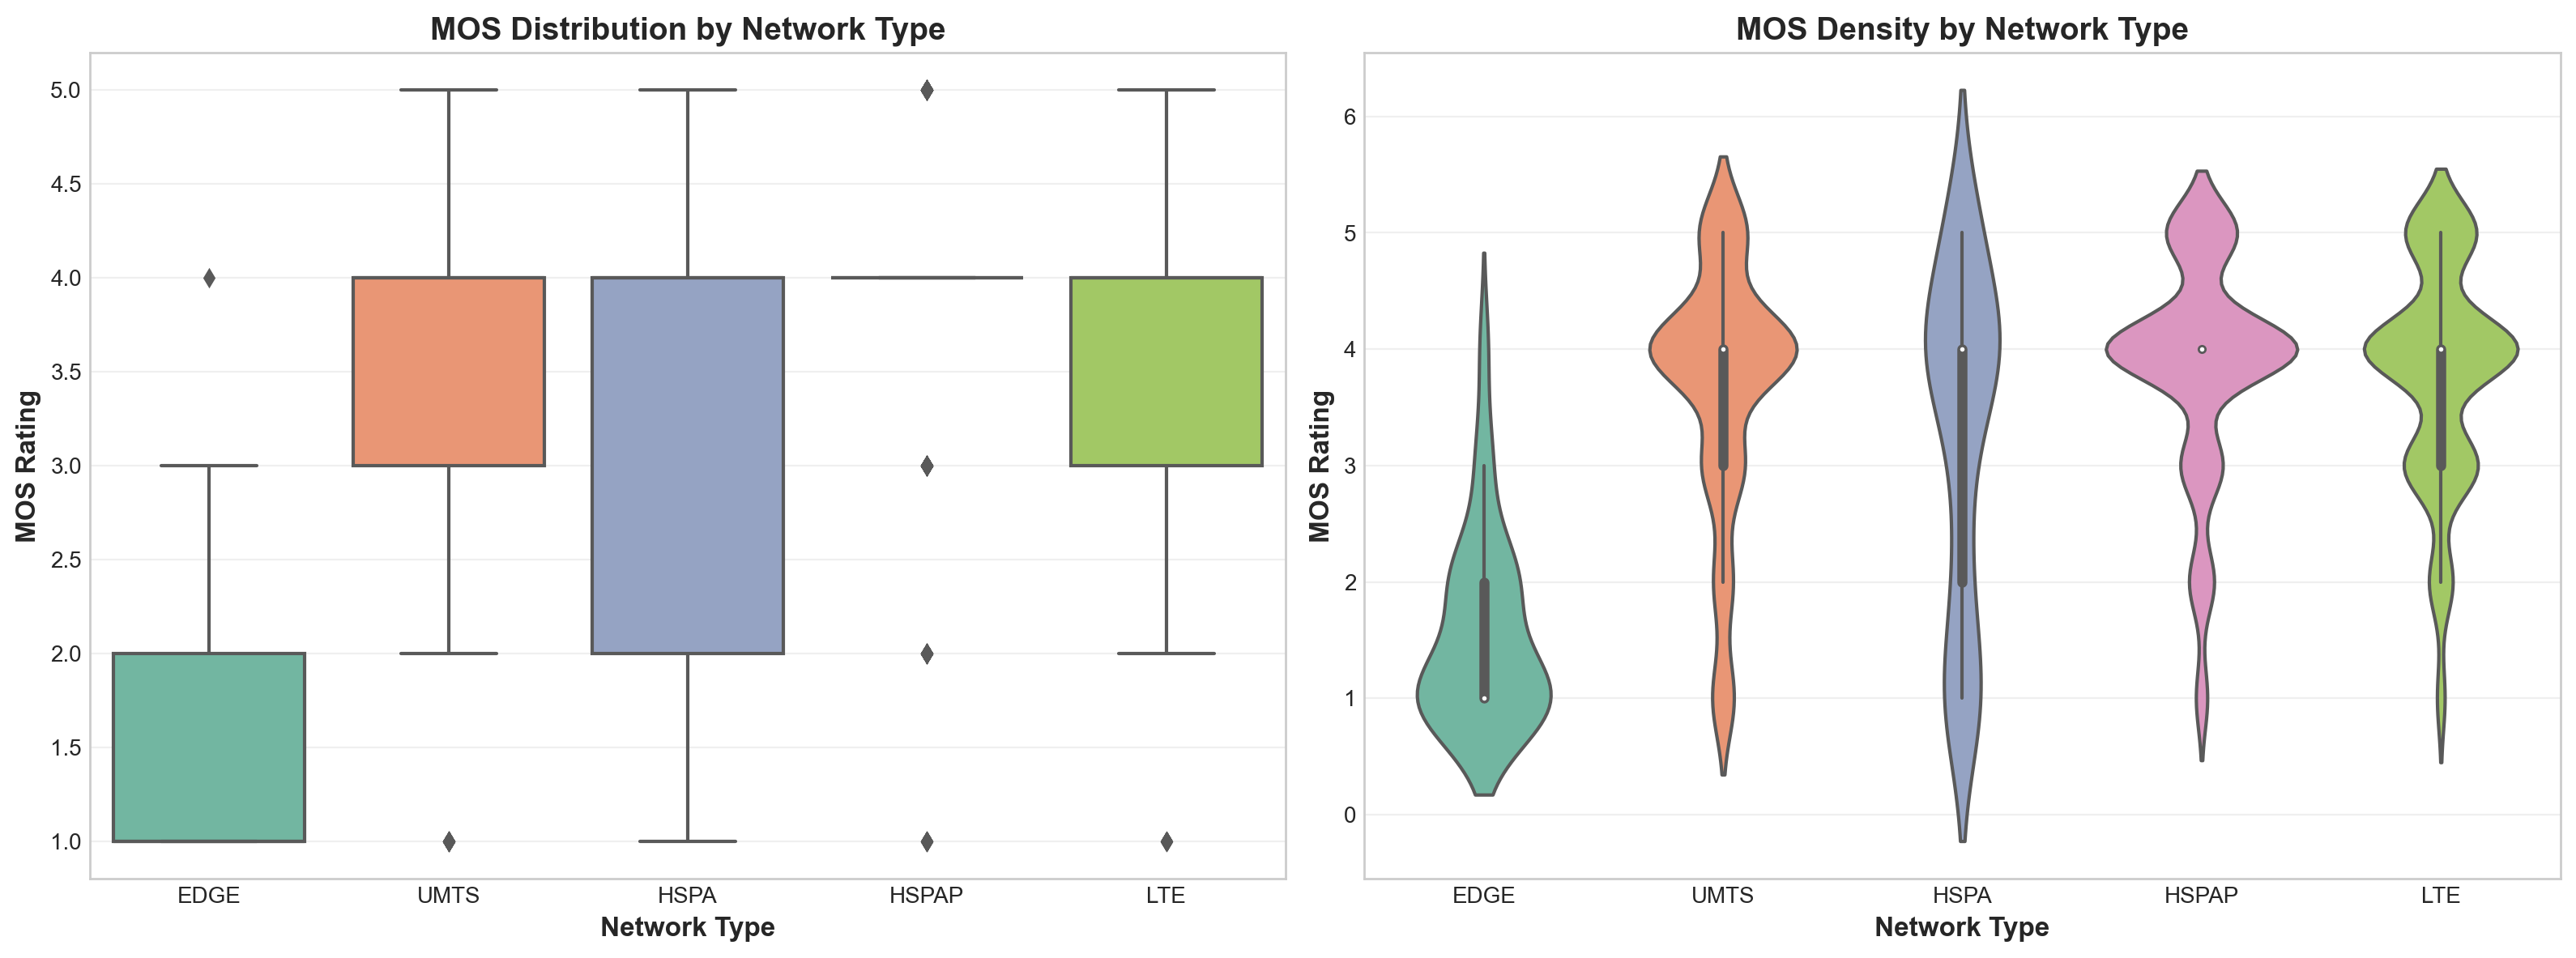

In [6]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
order = [n for n in network_order if n in df['Network_Type_Name'].unique()]
sns.boxplot(data=df, x='Network_Type_Name', y='MOS', order=order, ax=axes[0], palette='Set2')
axes[0].set_xlabel('Network Type', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MOS Rating', fontsize=12, fontweight='bold')
axes[0].set_title('MOS Distribution by Network Type', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Violin plot
sns.violinplot(data=df, x='Network_Type_Name', y='MOS', order=order, ax=axes[1], palette='Set2')
axes[1].set_xlabel('Network Type', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MOS Rating', fontsize=12, fontweight='bold')
axes[1].set_title('MOS Density by Network Type', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/network_type_vs_mos.png', dpi=300, bbox_inches='tight')
plt.show()

### Analysis:
**Hypothesis:** Better network technology (LTE) should yield higher MOS scores.

**Results:** [To be filled]

**Why these results?** [Explain if hypothesis confirmed or rejected]

## 4. Buffering Impact Analysis

**WHY:** Buffering is commonly cited as a major QoE degradation factor. Let's quantify its impact.

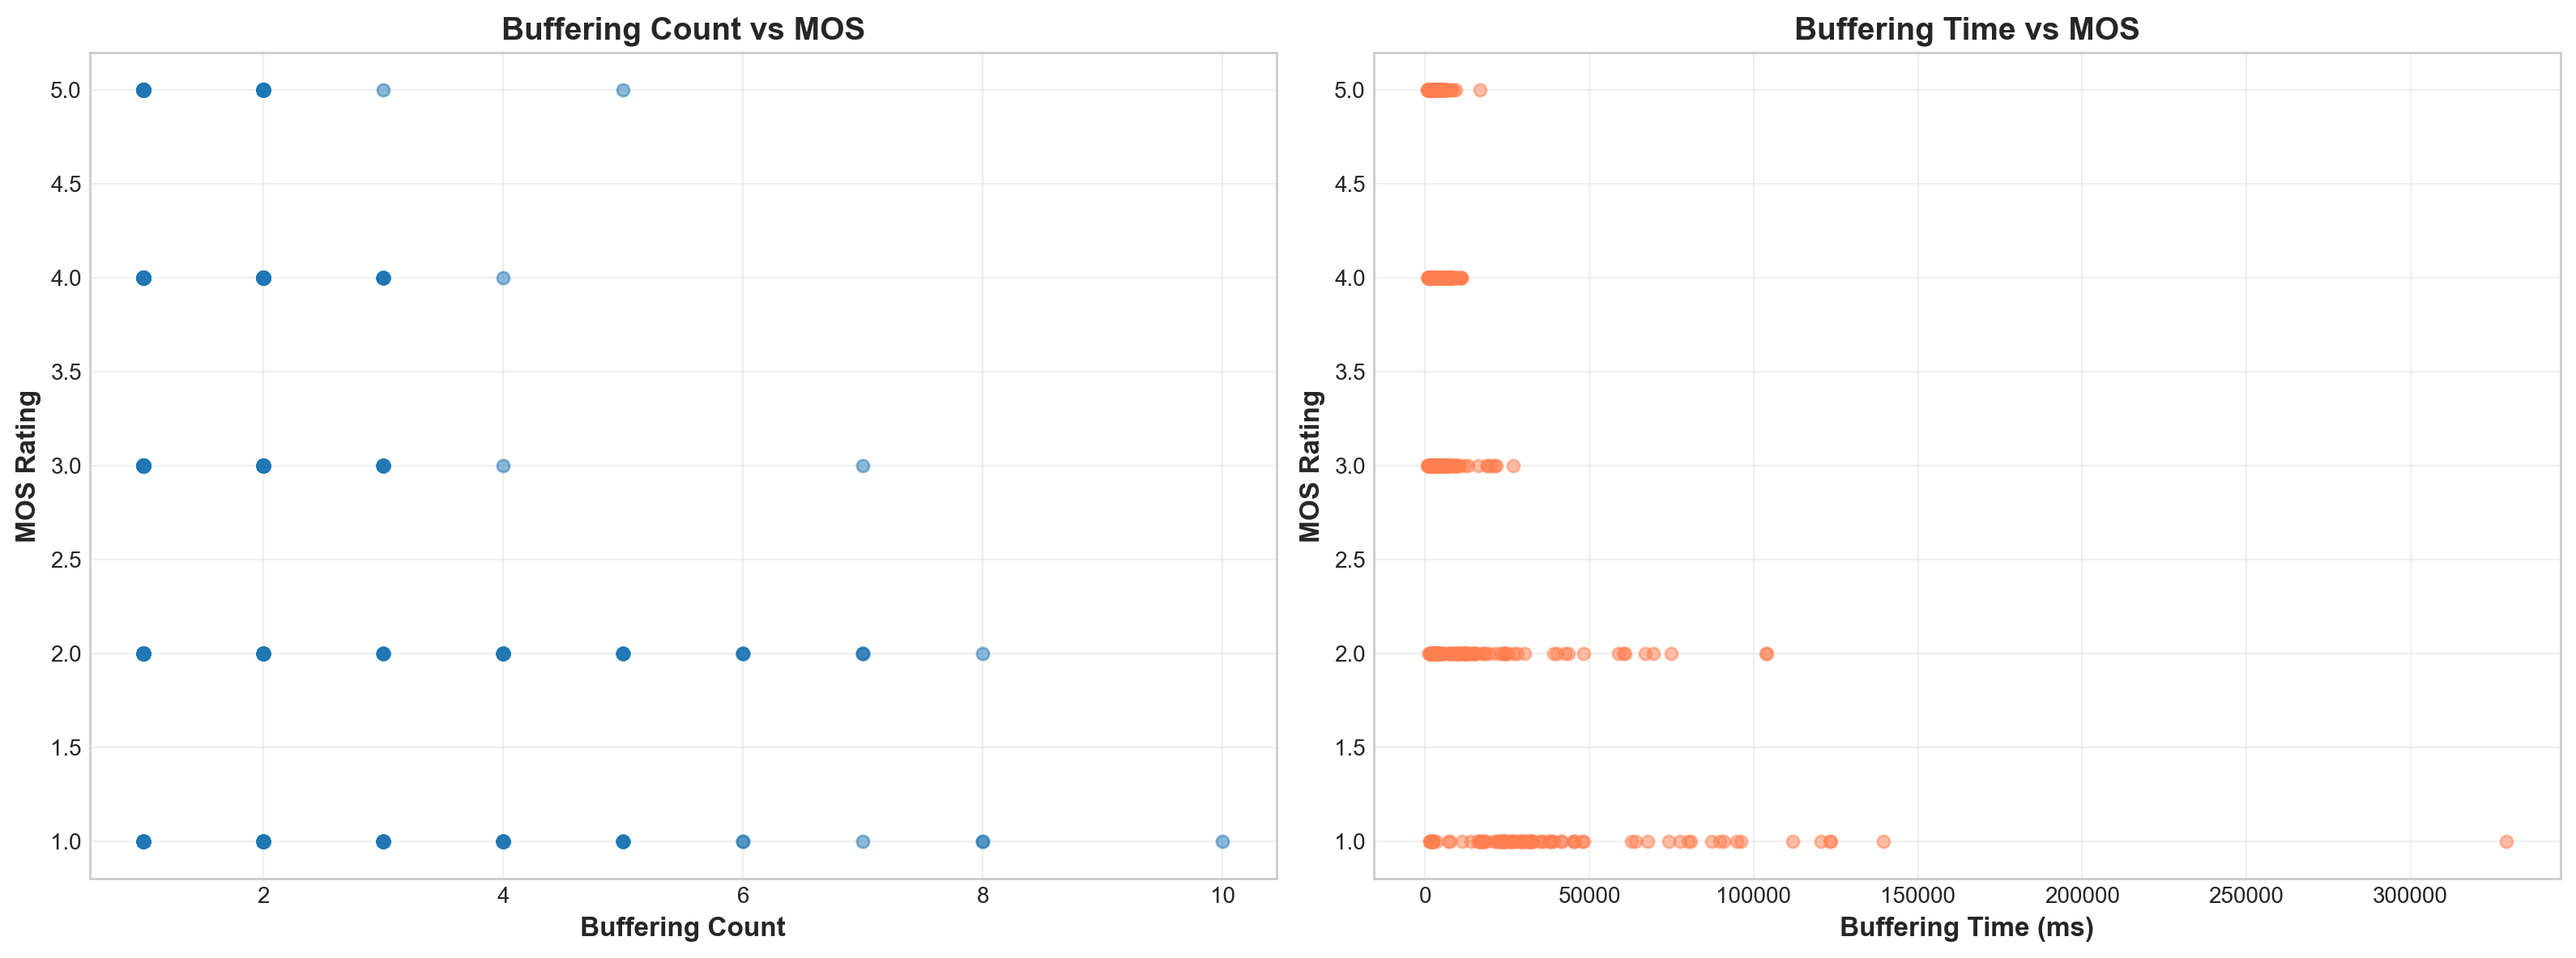

Correlation - Buffering Count vs MOS: -0.411
Correlation - Buffering Time vs MOS: -0.482


In [7]:
# Analyze buffering count vs MOS
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Buffering Count vs MOS
axes[0].scatter(df['QoA_BUFFERINGcount'], df['MOS'], alpha=0.5, s=30)
axes[0].set_xlabel('Buffering Count', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MOS Rating', fontsize=12, fontweight='bold')
axes[0].set_title('Buffering Count vs MOS', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Scatter plot: Buffering Time vs MOS
axes[1].scatter(df['QoA_BUFFERINGtime'], df['MOS'], alpha=0.5, s=30, color='coral')
axes[1].set_xlabel('Buffering Time (ms)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('MOS Rating', fontsize=12, fontweight='bold')
axes[1].set_title('Buffering Time vs MOS', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/buffering_vs_mos.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical analysis
buff_corr_count = df['QoA_BUFFERINGcount'].corr(df['MOS'])
buff_corr_time = df['QoA_BUFFERINGtime'].corr(df['MOS'])

print(f"Correlation - Buffering Count vs MOS: {buff_corr_count:.3f}")
print(f"Correlation - Buffering Time vs MOS: {buff_corr_time:.3f}")

## 5. Resolution Impact

**WHY:** Higher resolution typically means better quality, but also requires more bandwidth. How does it affect MOS?

MOS Statistics by Resolution:
                   Count  Mean_MOS  Std_MOS
QoA_VLCresolution                          
16                     1      3.00      NaN
240                   67      3.85     0.84
360                 1475      3.70     1.07


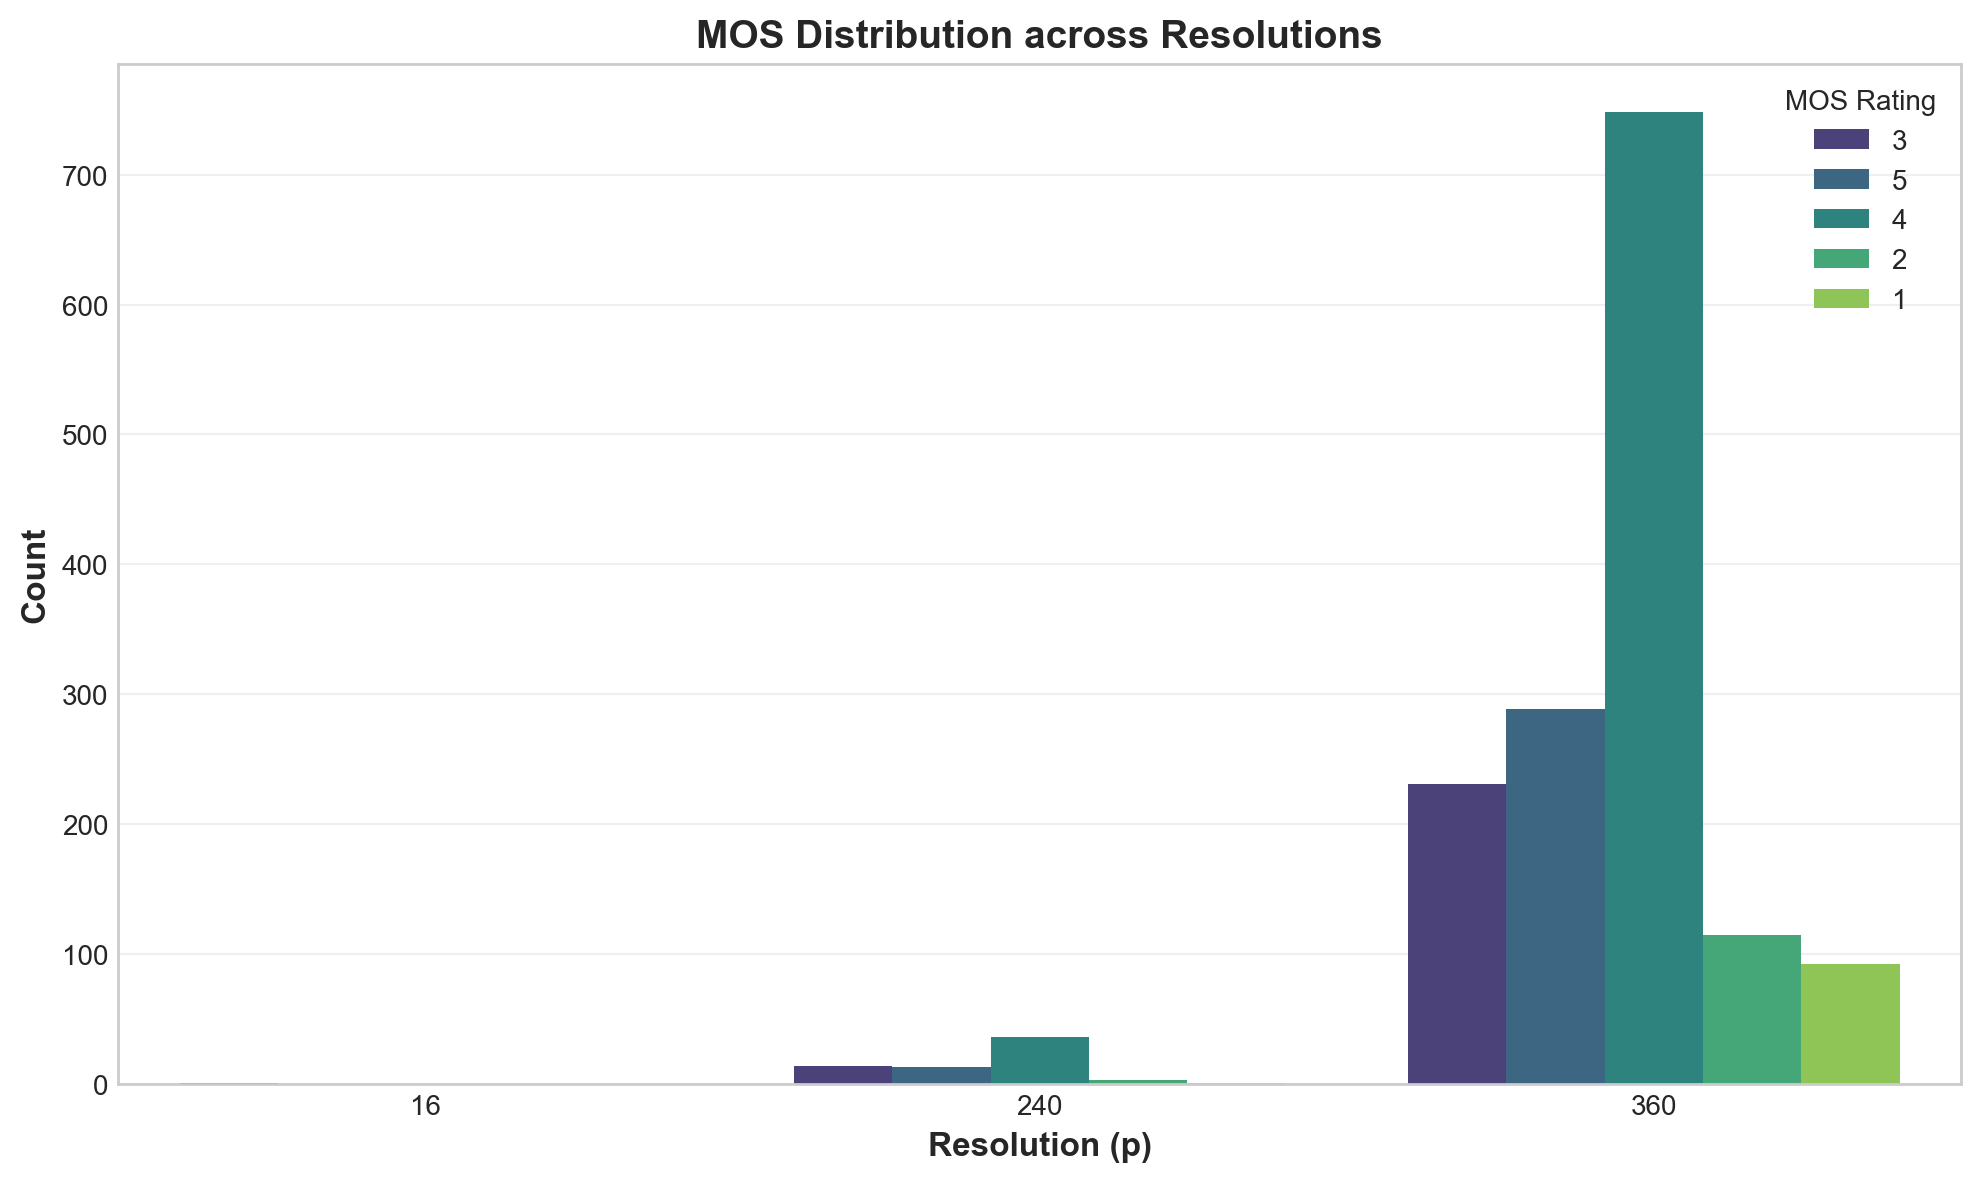

In [9]:
# MOS by Resolution
resolution_mos = df.groupby('QoA_VLCresolution')['MOS'].agg([
    ('Count', 'count'),
    ('Mean_MOS', 'mean'),
    ('Std_MOS', 'std')
]).round(2)

print("MOS Statistics by Resolution:")
print("="*50)
print(resolution_mos)

# Visualize
plt.figure(figsize=(10, 6))
# Convert MOS to string for proper legend handling
sns.countplot(data=df, x='QoA_VLCresolution', hue=df['MOS'].astype(str), palette='viridis')
plt.xlabel('Resolution (p)', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('MOS Distribution across Resolutions', fontsize=14, fontweight='bold')
plt.legend(title='MOS Rating', loc='upper right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('../results/figures/resolution_vs_mos.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. User Demographics Analysis

**WHY:** Different user groups might have different expectations and tolerance levels.

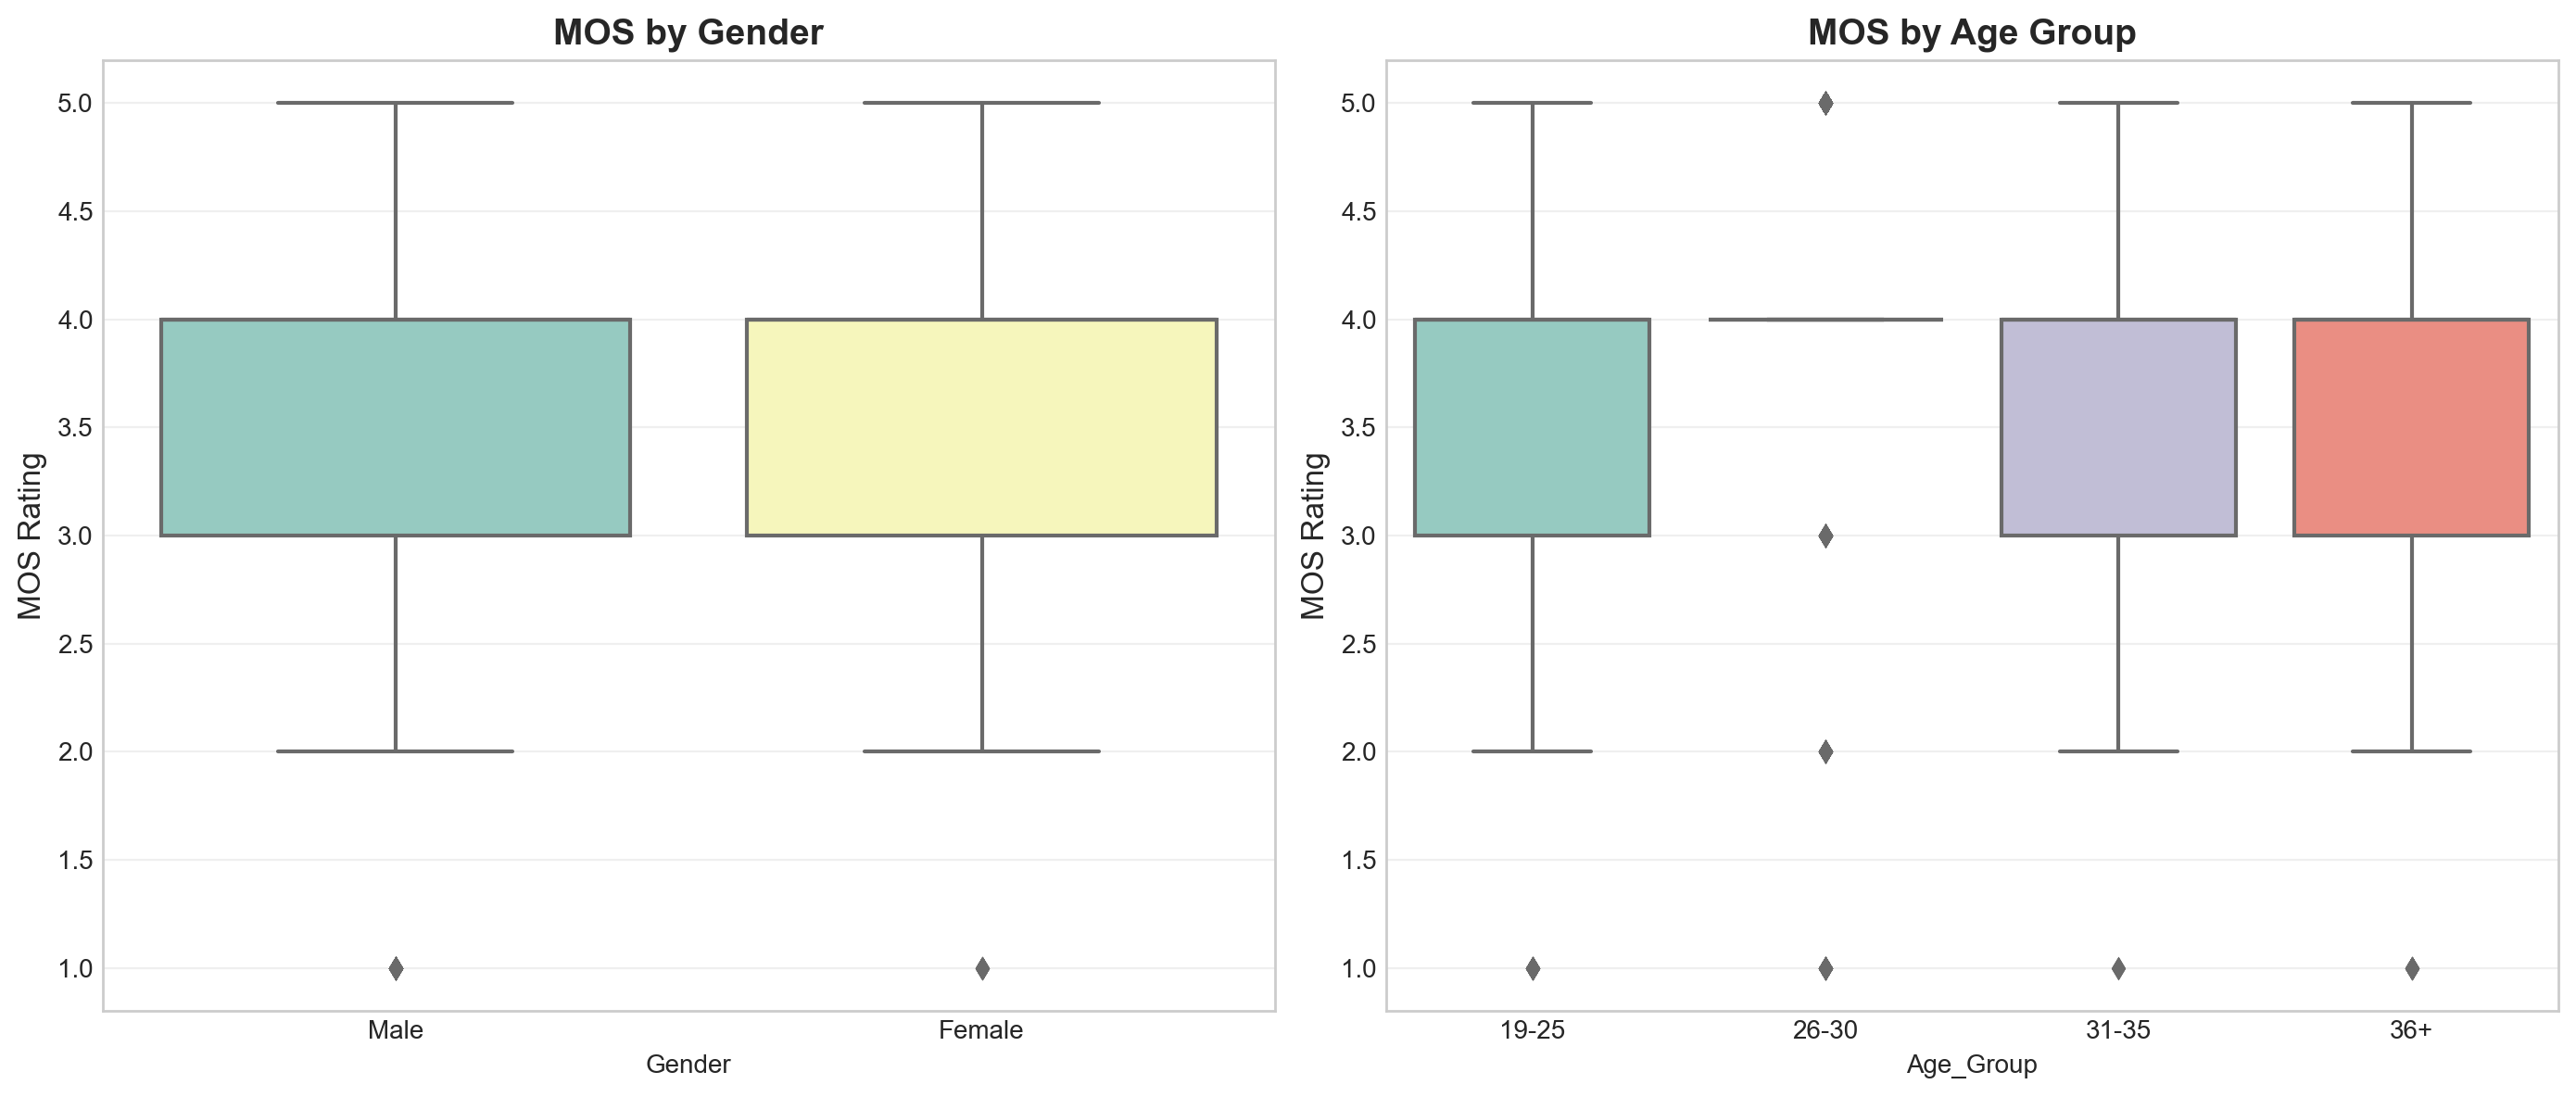


MOS by Gender:
         count  mean   std  min  25%  50%  75%  max
Gender                                             
Female   223.0  3.54  1.10  1.0  3.0  4.0  4.0  5.0
Male    1320.0  3.73  1.05  1.0  3.0  4.0  4.0  5.0

MOS by Age Group:
           count  mean   std  min  25%  50%  75%  max
Age_Group                                            
19-25      475.0  3.65  1.03  1.0  3.0  4.0  4.0  5.0
26-30      683.0  3.80  1.07  1.0  4.0  4.0  4.0  5.0
31-35      128.0  3.73  0.89  1.0  3.0  4.0  4.0  5.0
36+        257.0  3.54  1.12  1.0  3.0  4.0  4.0  5.0


In [8]:
# Gender impact
gender_mapping = {0: 'Female', 1: 'Male'}
df['Gender'] = df['QoU_sex'].map(gender_mapping)

# Age groups
df['Age_Group'] = pd.cut(df['QoU_age'], bins=[0, 25, 30, 35, 100], 
                         labels=['19-25', '26-30', '31-35', '36+'])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gender
sns.boxplot(data=df, x='Gender', y='MOS', ax=axes[0], palette='Set3')
axes[0].set_title('MOS by Gender', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MOS Rating', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)

# Age Group
sns.boxplot(data=df, x='Age_Group', y='MOS', ax=axes[1], palette='Set3')
axes[1].set_title('MOS by Age Group', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MOS Rating', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/demographics_vs_mos.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistics
print("\nMOS by Gender:")
print(df.groupby('Gender')['MOS'].describe().round(2))
print("\nMOS by Age Group:")
print(df.groupby('Age_Group')['MOS'].describe().round(2))

## 7. Key EDA Insights

### Main Findings (To be filled after running cells):

1. **Network Type Impact:**
   - [Summary of findings]
   - [Expected vs Actual]

2. **Buffering Influence:**
   - [Correlation strength]
   - [Implications for modeling]

3. **Resolution Effects:**
   - [Findings]

4. **User Demographics:**
   - [Gender/Age impact]

### Analysis Path (Storytelling):
[Explain how these findings connect and lead to next steps]

### Critical Assessment:
**Limitations:**
- [Correlation ≠ Causation]
- [Potential confounding factors]
- [Data collection biases]

### Next Steps:
1. Feature engineering based on insights
2. Preprocessing strategy
3. Model selection considerations